## Генерация полифонической музыки с кондишнингом

Импортируем torch и numpy:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import random

Сделаем также пользовательский импорт

In [2]:
from decode_patterns import data_conversion

In [3]:
data_height = 64
drum_width = 14
melody_width = 36
data_width = drum_width + melody_width
data_size = data_height*data_width
train_file = "decode_patterns/train.tsv" # обучающая выборка
validation_file = "decode_patterns/validation.tsv" # валидационная выборка
human_file = "decode_patterns/human.tsv" # как валидационная, только для ассесмента людей (read as "validation")

Загружаем датасет

In [4]:
# import dataset
drum, bass = data_conversion.make_lstm_dataset_conditioning(height=data_height,
                                                            patterns_file=train_file,
                                                            mono=False)

# define shuffling of dataset
def shuffle(A, B, p=0.8):
    # take 80% to training, other to testing
    AB = list(zip(A, B))
    L = len(AB)
    pivot = int(p*L)
    random.shuffle(AB)
    yield [p[0] for p in AB[:pivot]]
    yield [p[1] for p in AB[:pivot]]
    yield [p[0] for p in AB[pivot:]]
    yield [p[1] for p in AB[pivot:]]
    
    
# we can shuffle train and test set like this:
drum_train, bass_train, drum_test, bass_test = shuffle(drum, bass)

# selecting a validation set
drum_validation, bass_validation = data_conversion.make_lstm_dataset_conditioning(height=data_height,
                                                                                  patterns_file=validation_file,
                                                                                  mono=False)

In [5]:
bass[16]

NumpyImage(image=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), tempo=96, instrument=27, denominator=4, min_note=45)

Модель определим в самом простом варианте, который только можно себе представить -- как в примере с конечным автоматом

In [6]:
# Encoder = LSTM
# Decoder = FCNN
class DrumNBass_LSTM_to_FCNN(nn.Module):
    def __init__(self, bass_height, bass_width):
        super(DrumNBass_LSTM_to_FCNN, self).__init__()
        # save data parameters
        self.bass_height = bass_height
        self.bass_width = bass_width
        self.bass_size = bass_height*bass_width
        self.condition_size = 2 # размер подмешиваемого conditioning
        self.embedding_size = 4 # размер латентного пространства
        # one input neuron, one output neuron, one layer in LSTM block
        self.input_size = 14
        self.lstm_hidden_size = 4
        self.lstm_layer_count = 1
        self.lstm = nn.LSTM(self.input_size, self.lstm_hidden_size, self.lstm_layer_count)
        self.lstm_preembed_layer = nn.Linear(self.lstm_hidden_size, 1)
        self.lstm_embed_layer_mean = nn.Linear(self.bass_height, self.embedding_size)
        self.lstm_embed_layer_logvar = nn.Linear(self.bass_height, self.embedding_size)
        
        self.decoder_layer1 = nn.Linear(self.embedding_size + self.condition_size, 48)
        self.decoder_layer2 = nn.Linear(48 + self.condition_size, 512)
        self.decoder_layer3 = nn.Linear(512, self.bass_size)
        self.sigm = nn.Sigmoid()
        
    def encoder(self, input):
        # пусть в input у нас приходит вектор размерности (32, 128, 14)
        # где имеется 32 примера (минибатч) по 128 отсчётов, 14 значений в каждом (барабанная партия)
        # Тогда его надо транспонировать в размерность (128, 32, 14)
        input = input.transpose(0,1)
        output, _ = self.lstm(input)
        output = self.sigm(self.lstm_preembed_layer(output))
        # избавляемся от лишней размерности (embedding_size=1), чтобы получить вектор из lstm
        # размером с высоту изображения
        output = output.squeeze().transpose(0,1)
        mean = self.sigm(self.lstm_embed_layer_mean(output))
        logvar = self.sigm(self.lstm_embed_layer_logvar(output))
        return mean, logvar
    
    # reference:
    # https://github.com/pytorch/examples/blob/master/vae/main.py
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    # end reference
    
    def decoder(self, input, cond):
        output = torch.cat((input, cond), axis=1) # добавляем conditioning
        output = self.sigm(self.decoder_layer1(output))
        output = torch.cat((output, cond), axis=1) # добавляем ещё conditioning
        output = self.sigm(self.decoder_layer2(output))
        output = self.sigm(self.decoder_layer3(output))
        return output
    
    @staticmethod
    def get_images(input):
        return torch.tensor(list(map(lambda p: p.image, input)), dtype=torch.float)
    
    @staticmethod
    def get_conditionings(input):
        return torch.tensor(list(map(lambda p: [p.tempo, p.instrument], input)), dtype=torch.float)
    
    def forward(self, input):
        images = self.get_images(input)
        conditionings = self.get_conditionings(input)
        
        mean, logvar = self.encoder(images)
        # генерируем случайную точку в латентном пространстве
        result = self.reparameterize(mean, logvar)
        # добавляем conditioning
        result = self.decoder(result, conditionings)
        return result.view((-1, self.bass_height, self.bass_width)), mean, logvar

In [7]:
# часть обучения
dnb_lstm = DrumNBass_LSTM_to_FCNN(data_height, melody_width)

# criterion = nn.MSELoss() # -- с этим всё работает (точнее, работало)
# criterion = nn.NLLLoss() # -- этот товарищ требует, чтобы LSTM выдавал классы,
# criterion = nn.CrossEntropyLoss() # и этот тоже
# (числа от 0 до C-1), но как всё-таки его заставить это делать?...

# оценим также и разнообразие мелодии по её.. дисперсии?)
# def melody_variety(melody):
#     return 1/(1 + (melody.sum(axis=2) > 1).int())

# на самом деле, попробуем функцию потерь взять из VAE

def reconstruction_loss(recon_x, x):
    return F.binary_cross_entropy(recon_x, x, reduction='sum')

# Reference: https://github.com/pytorch/examples/blob/master/vae/main.py
# Reconstruction + KL divergence losses summed over all elements and batch
def reconstruction_KL_loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

optimizer = optim.Adam(dnb_lstm.parameters(), lr=0.001)
# optimizer = optim.SGD(dnb_lstm.parameters(), lr=0.001, momentum=0.9)

Посмотрим, как модель форвардится на один пример

In [8]:
dnb_lstm.forward([drum_validation[16], drum_validation[14], drum_validation[43]])[0].size()

torch.Size([3, 64, 36])

In [9]:
bass_validation[16].image.shape

(64, 36)

Найденные баги и их решения:

https://stackoverflow.com/questions/56741087/how-to-fix-runtimeerror-expected-object-of-scalar-type-float-but-got-scalar-typ

https://stackoverflow.com/questions/49206550/pytorch-error-multi-target-not-supported-in-crossentropyloss/49209628

https://stackoverflow.com/questions/56243672/expected-target-size-50-88-got-torch-size50-288-88

In [10]:
epoch_count = 72
batch_size = 64
shuffle_every_epoch = True
    
if shuffle_every_epoch:
    print(f"shuffle_every_epoch is on")
else:
    print(f"shuffle_every_epoch is off")
    # shuffle train and test set:
    drum_train, bass_train, drum_test, bass_test = shuffle(drum, bass)
        

def calc_loss_on(drum, bass, description):
    with torch.no_grad():
        batch_bass_raw = torch.tensor(list(map(lambda p: p.image, bass)), dtype=torch.float)
        bass_outputs, _, _ = dnb_lstm(drum)

        count = len(drum)
        loss = 0
        for k in range(count):
            loss += reconstruction_loss(bass_outputs[k], batch_bass_raw[k])
        print(f"#{epoch + 1} {description}: {loss/count}")

for epoch in range(epoch_count):  # loop over the dataset multiple times
    print(f"Epoch #{epoch}")
    if shuffle_every_epoch:
        # shuffle train and test set:
        drum_train, bass_train, drum_test, bass_test = shuffle(drum, bass)
        
    examples_count = len(drum_train)
    examples_id = 0
    
    running_loss = 0.0
    runnint_count = 0
    batch_id = 0
    while examples_id < examples_count:
        batch_drum_train = drum_train[examples_id:examples_id + batch_size]
        batch_bass_train = bass_train[examples_id:examples_id + batch_size]
        
        batch_bass_train_raw = torch.tensor(list(map(lambda p: p.image, batch_bass_train)), dtype=torch.float)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        bass_outputs, mu, stddev = dnb_lstm(batch_drum_train)
        # bass_outputs = bass_outputs.squeeze()
        
        # loss = criterion(bass_outputs, batch_bass_train_raw)
        loss = 0
        for i in range(batch_size):
            loss += reconstruction_KL_loss_function(bass_outputs[i], batch_bass_train_raw[i], mu[i], stddev[i])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        runnint_count += 1
        period = 5
        if batch_id % period == 0 or examples_id + batch_size >= examples_count:
            print('[%d, %5d] train loss: %.7f' %
                  (epoch + 1, batch_id + 1, running_loss / runnint_count))
            running_loss = 0.0
            runnint_count = 1
            
        # update batch info
        examples_id += batch_size
        batch_id += 1
        
    calc_loss_on(drum_test, bass_test, "reconstruction test loss")
    calc_loss_on(drum_validation, bass_validation, "reconstruction validation loss")
    torch.save(dnb_lstm.state_dict(), f"models/vae_lstm_fcnn_{epoch+1}iter")
print('Finished Training')

shuffle_every_epoch is on
Epoch #0
[1,     1] train loss: 105804.2578125
[1,     6] train loss: 52616.0625000
[1,    11] train loss: 19987.8354492
[1,    16] train loss: 9612.7210286
[1,    21] train loss: 7295.7250977
[1,    26] train loss: 6666.2264811
[1,    31] train loss: 6315.2217611
[1,    36] train loss: 6447.3212891
[1,    41] train loss: 6156.3768717
[1,    46] train loss: 6332.1488444
[1,    51] train loss: 5993.4137370
[1,    56] train loss: 6313.2171224
[1,    61] train loss: 5791.3854980
[1,    66] train loss: 5873.3064779
[1,    71] train loss: 5633.0908203
[1,    76] train loss: 5906.2965495
[1,    81] train loss: 5823.3674316
[1,    86] train loss: 5739.2776693
[1,    91] train loss: 6144.3256836
[1,    96] train loss: 6006.3346354
[1,   101] train loss: 6118.2699382
[1,   106] train loss: 5775.7169596
[1,   111] train loss: 5739.2664388
[1,   116] train loss: 5896.8026530
[1,   121] train loss: 5795.9636230
[1,   126] train loss: 6008.3368327
[1,   131] train loss: 59

[2,   486] train loss: 5634.8815918
[2,   491] train loss: 5629.1914876
[2,   496] train loss: 5943.8009440
[2,   501] train loss: 5963.3633626
[2,   506] train loss: 5850.4785156
[2,   511] train loss: 5818.7370605
[2,   516] train loss: 5936.6898600
[2,   521] train loss: 6008.4722493
[2,   526] train loss: 5801.3629557
[2,   531] train loss: 6169.0219727
[2,   536] train loss: 5915.4682617
[2,   541] train loss: 5867.3656413
[2,   546] train loss: 5777.4333496
[2,   551] train loss: 5614.3936361
[2,   556] train loss: 5782.3419596
[2,   561] train loss: 5697.6121419
[2,   566] train loss: 5710.6334635
[2,   571] train loss: 5749.7242839
[2,   576] train loss: 5676.2377930
[2,   581] train loss: 5799.5055339
[2,   586] train loss: 5946.7989095
[2,   591] train loss: 6069.9986165
[2,   596] train loss: 5887.3849284
[2,   601] train loss: 5826.8323568
[2,   606] train loss: 5867.7837728
[2,   611] train loss: 5689.9566243
[2,   616] train loss: 5693.1032715
[2,   621] train loss: 5743.

[4,   331] train loss: 5768.1092936
[4,   336] train loss: 5873.2028809
[4,   341] train loss: 5789.5212402
[4,   346] train loss: 5534.6745605
[4,   351] train loss: 5893.7458496
[4,   356] train loss: 5853.3947754
[4,   361] train loss: 5887.3005371
[4,   366] train loss: 6021.0426432
[4,   371] train loss: 5600.4338379
[4,   376] train loss: 5785.1264648
[4,   381] train loss: 5880.2336426
[4,   386] train loss: 6015.4890137
[4,   391] train loss: 5649.4558105
[4,   396] train loss: 5859.4031576
[4,   401] train loss: 5759.7727865
[4,   406] train loss: 5753.1685384
[4,   411] train loss: 5949.0105794
[4,   416] train loss: 6102.1461589
[4,   421] train loss: 5975.7138672
[4,   426] train loss: 5827.0171712
[4,   431] train loss: 5845.6149089
[4,   436] train loss: 5849.1099447
[4,   441] train loss: 5854.3510742
[4,   446] train loss: 5996.8532715
[4,   451] train loss: 5611.0284831
[4,   456] train loss: 5566.6844076
[4,   461] train loss: 5792.0371908
[4,   466] train loss: 5810.

[6,   176] train loss: 5793.0207520
[6,   181] train loss: 5731.3545736
[6,   186] train loss: 5716.6023763
[6,   191] train loss: 5765.0301107
[6,   196] train loss: 5781.4115397
[6,   201] train loss: 5815.5520020
[6,   206] train loss: 6143.3006999
[6,   211] train loss: 5749.3210449
[6,   216] train loss: 5620.5642904
[6,   221] train loss: 5735.5069987
[6,   226] train loss: 5611.2613932
[6,   231] train loss: 5718.7594401
[6,   236] train loss: 5694.2989095
[6,   241] train loss: 5886.6367188
[6,   246] train loss: 5941.6740723
[6,   251] train loss: 5806.9558919
[6,   256] train loss: 5824.2992350
[6,   261] train loss: 5689.2380371
[6,   266] train loss: 5593.1984049
[6,   271] train loss: 5801.4515788
[6,   276] train loss: 5679.5946452
[6,   281] train loss: 5726.9313965
[6,   286] train loss: 5749.4733073
[6,   291] train loss: 5675.8621419
[6,   296] train loss: 5825.6248372
[6,   301] train loss: 5728.3258464
[6,   306] train loss: 5728.0295410
[6,   311] train loss: 5811.

[8,    21] train loss: 5806.9367676
[8,    26] train loss: 5811.2036947
[8,    31] train loss: 5526.9556478
[8,    36] train loss: 5974.4786784
[8,    41] train loss: 5959.0399577
[8,    46] train loss: 5794.4942220
[8,    51] train loss: 5671.8584798
[8,    56] train loss: 6023.2110189
[8,    61] train loss: 5795.3387858
[8,    66] train loss: 5634.5518392
[8,    71] train loss: 6044.4486491
[8,    76] train loss: 5996.4563802
[8,    81] train loss: 5671.2041829
[8,    86] train loss: 5670.3341471
[8,    91] train loss: 5722.0139974
[8,    96] train loss: 5990.4619141
[8,   101] train loss: 5736.4930827
[8,   106] train loss: 5987.0069987
[8,   111] train loss: 5703.6520182
[8,   116] train loss: 5806.9321289
[8,   121] train loss: 5772.9077962
[8,   126] train loss: 5737.5008952
[8,   131] train loss: 5922.9871419
[8,   136] train loss: 5582.4762370
[8,   141] train loss: 5652.5767415
[8,   146] train loss: 5701.0604655
[8,   151] train loss: 5835.1996257
[8,   156] train loss: 5805.

KeyboardInterrupt: 

### Сохранение текущего состояния нейросети
Сохраим веса модели во внешний файл

In [11]:
torch.save(dnb_lstm.state_dict(), "models/vae_lstm_fcnn_32iter")

Аналогично происходит загрузка модели

In [12]:
dnb_lstm.load_state_dict(torch.load("models/vae_lstm_fcnn_32iter"))

<All keys matched successfully>

### Этап эксплуатации нейросети
Посмотрим на результаты, что выдаёт нейросеть на выходе...

In [13]:
with torch.no_grad():
    bass_outputs = dnb_lstm(drum_train)
result = bass_outputs[0].squeeze().int()
# result

Однако, более интересно посмотреть на то, что получилось в латентном пространстве... Неплохо было бы визуализировать точки в латентном пространстве

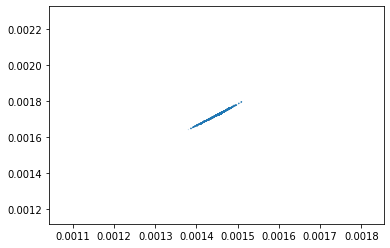

In [15]:
with torch.no_grad():
    latent_train = dnb_lstm.encoder(dnb_lstm.get_images(drum_train))
    
mu, dev = latent_train

# libraries
import matplotlib.pyplot as plt
import numpy as np
 
# create data
x = mu[:,0]
y = mu[:,1]
z = dev
 
# use the scatter function
plt.scatter(x, y, s=z*20, alpha=0.5)
plt.show()


Попробуем сохранить результаты работы сети. На anaconda нет mido, поэтому сохраняем результаты работы просто в массивчик npy... Однако, как альтернатива, его можно поставить чере pip в conda:
https://github.com/mido/mido/issues/198

In [39]:
import mido
from decode_patterns.data_conversion import build_track, DrumMelodyPair, NumpyImage, Converter


converter = Converter((data_height, data_width))

def output_midi(batch_drum, batch_bass, folder):
    with torch.no_grad():
        bass_outputs = dnb_lstm(batch_drum)[0]
        bass_outputs = ((bass_outputs.squeeze() + 1) / 2 > 0.55).int()

        for i in range(len(batch_drum)):

            img_dnb = np.concatenate((batch_drum[i].image,bass_outputs[i]), axis=1)
            numpy_pair = NumpyImage(np.array(img_dnb)
                                    , batch_drum[i].tempo
                                    , batch_drum[i].instrument
                                    , 1
                                    , batch_drum[i].min_note)
            pair = converter.convert_numpy_image_to_pair(numpy_pair)
            mid = build_track(pair, tempo=pair.tempo)
            mid.save(f"{folder}/sample{i+1}.mid")

Выводим обучающую и валидационную выборку

In [41]:
# # если очень надо послушать тренировчную -- лучше её перезагрузить, потому что она перемешивается
# drum, bass = data_conversion.make_lstm_dataset_conditioning(height=data_height,
#                                                             patterns_file=train_file,
#                                                             mono=False)
# output_midi(drum, bass, "midi/vae_lstm_fcnn/train")
output_midi(drum_validation, bass_validation, "midi/vae_lstm_fcnn/validation")

По вкусу, выводим тот же результат для кожанных мешков на ассесмент. На самом деле ничем от валидационной выборки не отличается :)

In [ ]:
drum_hum, bass_hum = data_conversion.make_lstm_dataset_conditioning(height=data_height, patterns_file=human_file, mono=False)
output_midi(drum_hum, bass_hum, "midi/vae_lstm_fcnn/human")

Попробуем сделать градиент от двух базовых партий!

In [ ]:

steps = 10 # количество шагов между семплами
sample1_id = 3
sample2_id = 49
sample1 = drum_validation[sample1_id]
sample2 = drum_validation[sample2_id]

# вычисляем два вектора в латентном пространстве
with torch.no_grad():
    latent_train = dnb_lstm.encoder(dnb_lstm.get_images([sample1, sample2]))
    mu, dev = latent_train

    sample1_latent = mu[0]
    sample2_latent = mu[1]
    
    # пробегаемся линейно по латентному пространству
    for step in range(steps + 1):
        alpha = step / steps
        latent_sample = sample1_latent + (sample2_latent - sample1_latent)*alpha
        
        # пока что выбираем соответствующую барабанную партию в двоичном виде
        drum_sample = sample1
        if (alpha >= 0.5):
            drum_sample = sample2
            
        # а параметры для кондишнинга -- линейно
        tempo = sample1.tempo + (sample2.tempo - sample1.tempo) * alpha
        instrument = sample1.instrument + (sample2.instrument - sample1.instrument) * alpha
        
        # декодируем линейную комбинацию
        conditionings = torch.tensor([tempo, instrument]).float()
        upsample = dnb_lstm.decoder(latent_sample.unsqueeze(dim=0), conditionings.unsqueeze(dim=0))
        upsample =  upsample.view((data_height, melody_width))
        upsample = ((upsample.squeeze() + 1) / 2 > 0.55)
        
        
        # сохраняем в файл
        img_dnb = np.concatenate((drum_sample.image,upsample), axis=1)
        numpy_pair = NumpyImage(np.array(img_dnb)
                                , tempo
                                , instrument
                                , 1
                                , drum_sample.min_note)
        pair = converter.convert_numpy_image_to_pair(numpy_pair)
        mid = build_track(pair, tempo=pair.tempo)
        mid.save(f"midi/vae_lstm_fcnn/grad/gradient{step}.mid")
        
